Visual crypto currency trading RL environment with real crypto exchange data
Chapter 4, TensorFlow 2 Reinforcement Learning Cookbook | Praveen Palanisamy

In [1]:
import os
import random
from typing import Dict

In [2]:
import cv2
import gym
import numpy as np
import pandas as pd
from gym import spaces

In [3]:
from trading_utils import TradeVisualizer

In [4]:
env_config = {
    "exchange": "Gemini",  # Crypto currency exchange (Gemini, coinbase, kraken, etc.)
    "ticker": "ETHUSD",  # CryptoFiat
    "frequency": "daily",  # daily/hourly/minutes
    "opening_account_balance": 100000,
    # Number of steps (days) of data provided to the agent in one observation
    "observation_horizon_sequence_length": 30,
    "order_size": 1,  # Number of coins to buy per buy/sell order
}

In [5]:
class CryptoTradingVisualEnv(gym.Env):
    def __init__(self, env_config: Dict = env_config):
        """Crypto trading environment for RL agents
        The observations are crypto price info (OHLCV) over a horizon as specified
        in env_config. Action space is discrete to perform buy/sell/hold trades.
        Args:
            ticker (str, optional): Ticker symbol for the crypto-fiat currentcy pair.
            Defaults to "ETHUSD".
            env_config (Dict): Env configuration values
        """
        super(CryptoTradingVisualEnv, self).__init__()
        self.ticker = env_config.get("ticker", "ETHUSD")
        data_dir = "data"
        self.exchange = env_config["exchange"]
        freq = env_config["frequency"]
        if freq == "daily":
            self.freq_suffix = "d"
        elif freq == "hourly":
            self.freq_suffix = "1hr"
        elif freq == "minutes":
            self.freq_suffix = "1min"

        self.ticker_file_stream = os.path.join(
            f"{data_dir}",
            f"{'_'.join([self.exchange, self.ticker, self.freq_suffix])}.csv",
        )
        assert os.path.isfile(
            self.ticker_file_stream
        ), f"Crypto data file stream not found at: data/{self.ticker_file_stream}.csv"
        # Crypto exchange data stream. An offline file stream is used. Alternatively, a web
        # API can be used to pull live data.
        self.ohlcv_df = (
            pd.read_csv(self.ticker_file_stream, skiprows=1)
            .sort_values(by="Date")
            .reset_index(drop=True)
        )

        self.opening_account_balance = env_config["opening_account_balance"]
        # Action: 0-> Hold; 1-> Buy; 2 ->Sell;
        self.action_space = spaces.Discrete(3)

        self.observation_features = [
            "Open",
            "High",
            "Low",
            "Close",
            "Volume ETH",
            "Volume USD",
        ]
        self.obs_width, self.obs_height = 128, 128
        self.horizon = env_config.get("observation_horizon_sequence_length")
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(128, 128, 3),
            dtype=np.uint8,
        )
        self.order_size = env_config.get("order_size")
        self.viz = None  # Visualizer

    def step(self, action):
        # Execute one step within the trading environment
        self.execute_trade_action(action)

        self.current_step += 1

        reward = self.account_value - self.opening_account_balance  # Profit (loss)
        done = self.account_value <= 0 or self.current_step >= len(
            self.ohlcv_df.loc[:, "Open"].values
        )

        obs = self.get_observation()

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.cash_balance = self.opening_account_balance
        self.account_value = self.opening_account_balance
        self.num_coins_held = 0
        self.cost_basis = 0
        self.current_step = 0
        self.trades = []
        if self.viz is None:
            self.viz = TradeVisualizer(
                self.ticker,
                self.ticker_file_stream,
                "TFRL-Cookbook Ch4-CryptoTradingVisualEnv",
                skiprows=1,
            )

        return self.get_observation()

    def render(self, **kwargs):
        # Render the environment to the screen

        if self.current_step > self.horizon:
            self.viz.render(
                self.current_step,
                self.account_value,
                self.trades,
                window_size=self.horizon,
            )

    def close(self):
        if self.viz is not None:
            self.viz.close()
            self.viz = None

    def get_observation(self):
        """Return a view of the Ticker price chart as image observation

        Returns:
            img_observation (np.ndarray): Image of ticker candle stick plot
            with volume bars as observation
        """
        img_observation = self.viz.render_image_observation(
            self.current_step, self.horizon
        )
        img_observation = cv2.resize(
            img_observation, dsize=(128, 128), interpolation=cv2.INTER_CUBIC
        )

        return img_observation

    def execute_trade_action(self, action):
        if action == 0:  # Hold position
            return
        order_type = "buy" if action == 1 else "sell"

        # Stochastically determine the current stock price based on Market Open & Close
        current_price = random.uniform(
            self.ohlcv_df.loc[self.current_step, "Open"],
            self.ohlcv_df.loc[self.current_step, "Close"],
        )
        if order_type == "buy":
            allowable_coins = int(self.cash_balance / current_price)
            if allowable_coins < self.order_size:
                # Not enough cash to execute a buy order
                return
            # Simulate a BUY order and execute it at current_price
            num_coins_bought = self.order_size
            current_cost = self.cost_basis * self.num_coins_held
            additional_cost = num_coins_bought * current_price

            self.cash_balance -= additional_cost
            self.cost_basis = (current_cost + additional_cost) / (
                self.num_coins_held + num_coins_bought
            )
            self.num_coins_held += num_coins_bought

            self.trades.append(
                {
                    "type": "buy",
                    "step": self.current_step,
                    "shares": num_coins_bought,
                    "proceeds": additional_cost,
                }
            )

        elif order_type == "sell":
            # Simulate a SELL order and execute it at current_price
            if self.num_coins_held < self.order_size:
                # Not enough coins to execute a sell order
                return
            num_coins_sold = self.order_size
            self.cash_balance += num_coins_sold * current_price
            self.num_coins_held -= num_coins_sold
            sale_proceeds = num_coins_sold * current_price

            self.trades.append(
                {
                    "type": "sell",
                    "step": self.current_step,
                    "shares": num_coins_sold,
                    "proceeds": sale_proceeds,
                }
            )
        if self.num_coins_held == 0:
            self.cost_basis = 0
        # Update account value
        self.account_value = self.cash_balance + self.num_coins_held * current_price

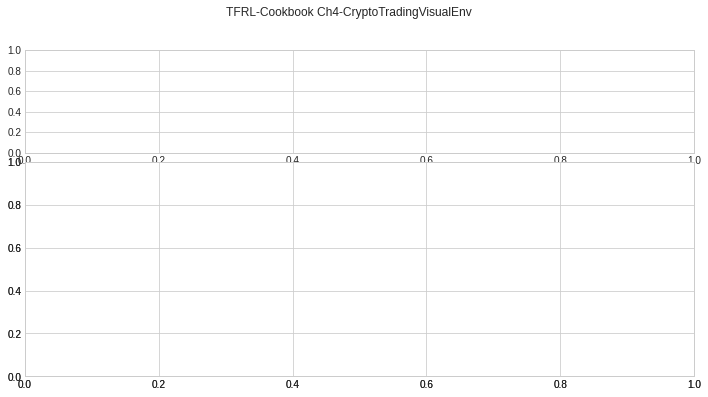

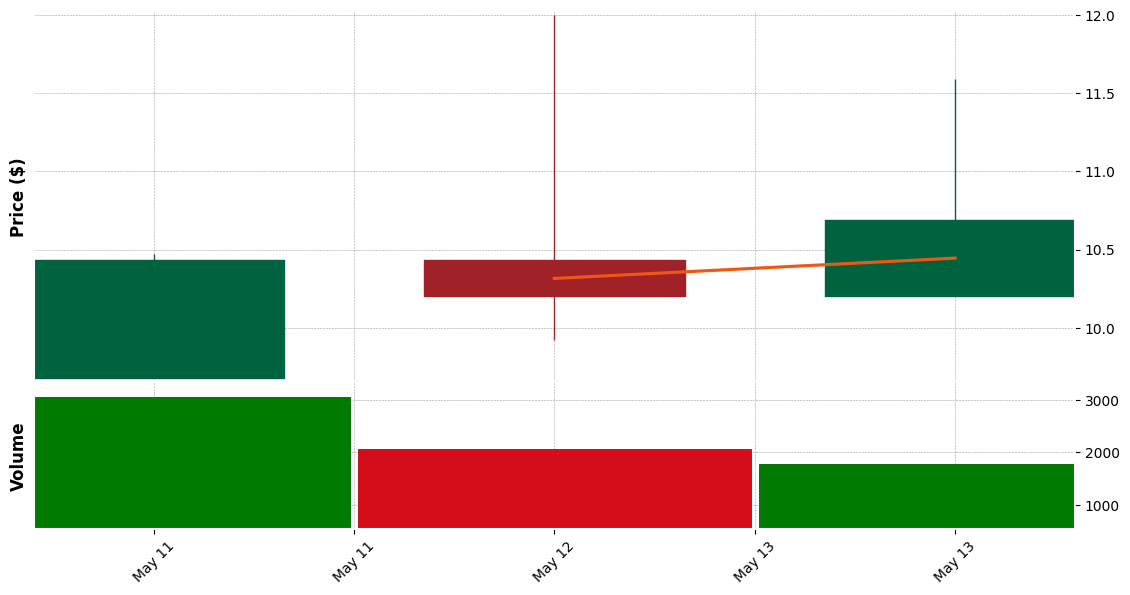

In [6]:
if __name__ == "__main__":
    env = CryptoTradingVisualEnv()
    obs = env.reset()
    num_episodes = 2  # Increase num_episodes
    for _ in range(num_episodes):
        action = env.action_space.sample()
        next_obs, reward, done, _ = env.step(action)
        env.render()